# Notebook initialization

## Selecting best GPU to execute on

In [2]:
import os
os.environ['PYTHONHASHSEED'] = '0'
import gpustat

stats = gpustat.GPUStatCollection.new_query()
ids = map(lambda gpu: int(gpu.entry['index']), stats)
ratios = map(lambda gpu: float(gpu.entry['memory.used'])/float(gpu.entry['memory.total']), stats)
bestGPU = 0#min(zip(ids, ratios), key=lambda x: x[1])[0]

print("setGPU: Setting GPU to: {}".format(bestGPU))
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = str(bestGPU)

setGPU: Setting GPU to: 0


##  Global variables

In [3]:
# IPython extension to reload modules before executing user code.
# 'autoreload' reloads modules automatically before entering the execution of code typed at the IPython prompt.
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(0, "../")

In [4]:
# with open('simulation_id.txt', 'r') as f:
#     simulation_id = int(f.read())

#with open('simulation_id.txt', 'w') as f:
 #   f.write(str(simulation_id))

simulation_id = 6

In [5]:
weights_path = lambda wid, name: '../weights/{}/{}/'.format(wid, name)
dw_path = lambda wid, name: '../dw/{}/{}/'.format(wid, name)
figures_path = lambda name: 'figures/{}/{}/'.format(simulation_id, name)

In [6]:
print(simulation_id)
import datetime

6


## Seed initialization (for reproductible results)

In [7]:
# Setting the seed for NumPy generated random numbers
import numpy as np
np.random.seed(0)

# Setting the seed for Python random numbers
import random as rn
rn.seed(0)

# Setting the seed for TensorFlow random numbers
import tensorflow as tf
tf.set_random_seed(0)

#from keras.backend.tensorflow_backend import set_session
#config = tf.ConfigProto()
#config.gpu_options.per_process_gpu_memory_fraction = 0.5
#set_session(tf.Session(config=config))

# Importing packages

## User defined packages

In [8]:
from data_utils import *
from keras_utils import plot_layerwise_angle_deviation_curves, LayerwiseAngleDeviationCurves, LearningRateMonitor, TerminateOnBaseline, get_kernel_layer_names
from models import VGG16_beta

Using TensorFlow backend.


## Other packages

In [9]:
from keras import optimizers
from keras import callbacks
from keras.models import clone_model
from keras.callbacks import LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from collections import defaultdict
import scipy
import matplotlib.pyplot as plt
import pathlib
import pickle
from layca_optimizers import SGD
from keras_utils import get_kernel_layer_names, get_kernel_layer, get_kernel_weights

In [10]:
## Import up sound alert dependencies
from IPython.display import Audio, display

def allDone():
  display(Audio(url='http://noproblo.dayjo.org/ZeldaSounds/TP/TP_Secret.wav', autoplay=True))
## Insert whatever audio file you want above

# Initialization of the models

In [11]:
num_classes = 10

In [12]:
(x_train, y_train), (x_test, y_test) = import_cifar(num_classes)

In [13]:
models = {  
    'vgg16_sgd_0':      VGG16_beta(input_shape=(32,32,3), num_classes=num_classes, weight_decay=0.0),
    'vgg16_sgd_1':      VGG16_beta(input_shape=(32,32,3), num_classes=num_classes, weight_decay=0.0),
    'vgg16_sgd_2':      VGG16_beta(input_shape=(32,32,3), num_classes=num_classes, weight_decay=0.0),
    
    'vgg16_wdecay_0':   VGG16_beta(input_shape=(32,32,3), num_classes=num_classes, weight_decay=0.001),
    'vgg16_wdecay_1':   VGG16_beta(input_shape=(32,32,3), num_classes=num_classes, weight_decay=0.001),
    'vgg16_wdecay_2':   VGG16_beta(input_shape=(32,32,3), num_classes=num_classes, weight_decay=0.001),
    
    'vgg16_layca_0':    VGG16_beta(input_shape=(32,32,3), num_classes=num_classes, weight_decay=0.0),
    'vgg16_layca_1':    VGG16_beta(input_shape=(32,32,3), num_classes=num_classes, weight_decay=0.0),
    'vgg16_layca_2':    VGG16_beta(input_shape=(32,32,3), num_classes=num_classes, weight_decay=0.0)
} 

In [14]:
model_names = [name for name, model in models.items()]

In [15]:
layer_names = [name.split('_', 1)[0] for name in get_kernel_layer_names(list(models.values())[0])]
n_layers = len(get_kernel_layer_names(list(models.values())[0]))

In [16]:
for name in model_names:
    pathlib.Path(weights_path(simulation_id, name) + 'initial/').mkdir(parents=True, exist_ok=True) 
    pathlib.Path(weights_path(simulation_id, name) + 'final/').mkdir(parents=True, exist_ok=True) 
    pathlib.Path(weights_path(simulation_id, name) + 'byepoch/').mkdir(parents=True, exist_ok=True) 
    pathlib.Path(figures_path(name)).mkdir(parents=True, exist_ok=True)

In [17]:
for name, model in models.items():
    pathlib.Path(figures_path(name) + 'byepoch').mkdir(parents=True, exist_ok=True)
    pathlib.Path(dw_path(simulation_id, name) + 'byepoch/').mkdir(parents=True, exist_ok=True) 

In [128]:
models['vgg16_sgd_0'].save_weights(weights_path(simulation_id, 'vgg16_sgd_0') + 'initial/weights-initial.hdf5') 

In [129]:
for name, model in models.items():
    if name != 'vgg16_sgd_0':
        model.load_weights(weights_path(simulation_id, 'vgg16_sgd_0') + 'initial/weights-initial.hdf5')

In [130]:
for name, model in models.items():
    if name != 'vgg16_sgd_0':
        model.save_weights(weights_path(simulation_id, name) + 'initial/weights-initial.hdf5')

In [131]:
allDone()

# Training the models

In [24]:
def train(model_name, lr, epochs, batch_size, validation_split, momentum, layca):#, lr_decay):  
           
    with open(weights_path(simulation_id, model_name) + 'parameters.pickle', 'wb') as handle:
        pickle.dump({'date': datetime.datetime.now(),
                     'lr': lr, 
                     'epochs': epochs,
                     'batch_size': batch_size,
                     'validation_split': validation_split,
                     'momentum': momentum
                    }, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    model = models[model_name]
    model.load_weights(weights_path(simulation_id, model_name) + 'initial/weights-initial.hdf5') 
    
    ladc = LayerwiseAngleDeviationCurves()
    lrm = LearningRateMonitor()
    callbacks = [ladc, lrm]
#     if lr_decay:
    callbacks += [ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1)]
    callbacks += [TerminateOnBaseline(monitor='acc', baseline=0.99)]
#     callbacks += [EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5)]
    callbacks += [ModelCheckpoint(weights_path(simulation_id, model_name) + 'byepoch/weights-{epoch:02d}.hdf5', save_weights_only=True)]
#     callbacks += [Accumulate(batch_size, model_name)]
    
    # Optimization details
    sgd = SGD(lr=lr, momentum=momentum, nesterov=True, layca=layca)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    
    hist = model.fit(x=x_train, 
                     y=y_train,
                     validation_split=validation_split,
                     batch_size=batch_size, 
                     epochs=epochs, 
                     verbose=1, 
                     callbacks=callbacks)
    
    with open(weights_path(simulation_id, model_name) + 'history.pickle', 'wb') as handle:
        pickle.dump(hist.history, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
    with open(weights_path(simulation_id, model_name) + 'cosines.pickle', 'wb') as handle:
        pickle.dump(ladc.memory, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
    with open(weights_path(simulation_id, model_name) + 'lrates.pickle', 'wb') as handle:
        pickle.dump(lrm.lrates, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    fig, ax = plt.subplots(nrows=1, ncols=1)
    plot_layerwise_angle_deviation_curves(ladc.memory, ax)
    fig.savefig(figures_path(model_name) + 'cosine_dist.png', dpi=100)
    
    allDone()

## SGD

Train on 40000 samples, validate on 10000 samples
Epoch 1/50
40000/40000 [==============================] - 18s 462us/step - loss: 2.0247 - acc: 0.2135 - val_loss: 2.8895 - val_acc: 0.0980
current learning rate: 0.10000000149011612
Epoch 2/50
40000/40000 [==============================] - 17s 425us/step - loss: 1.6602 - acc: 0.3828 - val_loss: 2.5115 - val_acc: 0.1681
current learning rate: 0.10000000149011612
Epoch 3/50
40000/40000 [==============================] - 17s 431us/step - loss: 1.3875 - acc: 0.5222 - val_loss: 1.8118 - val_acc: 0.3491
current learning rate: 0.10000000149011612
Epoch 4/50
40000/40000 [==============================] - 17s 425us/step - loss: 1.1499 - acc: 0.6312 - val_loss: 1.6215 - val_acc: 0.4877
current learning rate: 0.10000000149011612
Epoch 5/50
40000/40000 [==============================] - 18s 441us/step - loss: 0.9949 - acc: 0.7002 - val_loss: 1.2024 - val_acc: 0.6231
current learning rate: 0.10000000149011612
Epoch 6/50
40000/40000 [================

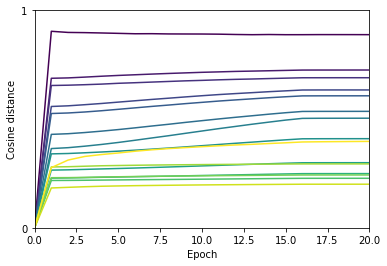

In [26]:
train(model_name='vgg16_sgd_2', lr=0.1, epochs=50, batch_size=128, validation_split=0.2, momentum=0.9, layca=False)#, lr_decay=True)

Train on 40000 samples, validate on 10000 samples
Epoch 1/50
40000/40000 [==============================] - 31s 778us/step - loss: 1.4300 - acc: 0.5128 - val_loss: 1.4402 - val_acc: 0.5174
current learning rate: 0.003000000026077032
Epoch 2/50
40000/40000 [==============================] - 19s 463us/step - loss: 1.0646 - acc: 0.6765 - val_loss: 1.1512 - val_acc: 0.6490
current learning rate: 0.003000000026077032
Epoch 3/50
40000/40000 [==============================] - 19s 473us/step - loss: 0.8790 - acc: 0.7609 - val_loss: 1.0407 - val_acc: 0.6914
current learning rate: 0.003000000026077032
Epoch 4/50
40000/40000 [==============================] - 19s 471us/step - loss: 0.7245 - acc: 0.8321 - val_loss: 1.0895 - val_acc: 0.6750
current learning rate: 0.003000000026077032
Epoch 5/50
40000/40000 [==============================] - 19s 472us/step - loss: 0.5891 - acc: 0.8953 - val_loss: 1.0432 - val_acc: 0.7015
current learning rate: 0.003000000026077032
Epoch 6/50
40000/40000 [===========

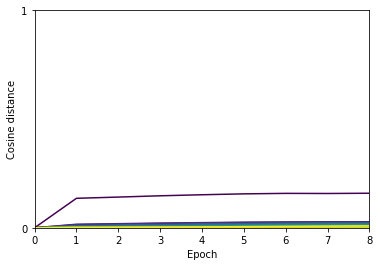

In [164]:
train(model_name='vgg16_sgd_1', lr=0.003, epochs=50, batch_size=128, validation_split=0.2, momentum=0.9, layca=False)#, lr_decay=True)

Train on 40000 samples, validate on 10000 samples
Epoch 1/50
40000/40000 [==============================] - 27s 663us/step - loss: 1.5976 - acc: 0.4455 - val_loss: 1.6535 - val_acc: 0.4080
current learning rate: 0.0012499999720603228
Epoch 2/50
40000/40000 [==============================] - 14s 349us/step - loss: 1.2340 - acc: 0.6061 - val_loss: 1.2940 - val_acc: 0.5787
current learning rate: 0.0012499999720603228
Epoch 3/50
40000/40000 [==============================] - 14s 356us/step - loss: 1.0405 - acc: 0.6999 - val_loss: 1.2559 - val_acc: 0.6012
current learning rate: 0.0012499999720603228
Epoch 4/50
40000/40000 [==============================] - 15s 369us/step - loss: 0.8784 - acc: 0.7851 - val_loss: 1.2599 - val_acc: 0.6065
current learning rate: 0.0012499999720603228
Epoch 5/50
40000/40000 [==============================] - 14s 359us/step - loss: 0.7209 - acc: 0.8687 - val_loss: 1.2341 - val_acc: 0.6302
current learning rate: 0.0012499999720603228
Epoch 6/50
40000/40000 [======

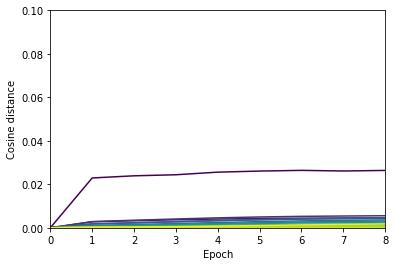

In [165]:
train(model_name='vgg16_sgd_0', lr=0.00125, epochs=50, batch_size=256, validation_split=0.2, momentum=0.9, layca=False)#, lr_decay=False)

## Weight decay

In [ ]:
train(model_name='vgg16_wdecay_2', lr=0.12, epochs=50, batch_size=128, validation_split=0.2, momentum=0.9, layca=False)#, lr_decay=True)

Train on 40000 samples, validate on 10000 samples
Epoch 1/50
40000/40000 [==============================] - 20s 501us/step - loss: 9.0215 - acc: 0.2390 - val_loss: 5.9744 - val_acc: 0.0997
current learning rate: 0.11999999731779099
Epoch 2/50
40000/40000 [==============================] - 18s 454us/step - loss: 3.1793 - acc: 0.4874 - val_loss: 4.0460 - val_acc: 0.1259
current learning rate: 0.11999999731779099
Epoch 3/50
40000/40000 [==============================] - 18s 453us/step - loss: 1.7618 - acc: 0.6079 - val_loss: 2.6602 - val_acc: 0.2474
current learning rate: 0.11999999731779099
Epoch 4/50
40000/40000 [==============================] - 18s 453us/step - loss: 1.4218 - acc: 0.6721 - val_loss: 2.0214 - val_acc: 0.4448
current learning rate: 0.11999999731779099
Epoch 5/50
40000/40000 [==============================] - 18s 448us/step - loss: 1.3338 - acc: 0.7080 - val_loss: 1.7363 - val_acc: 0.5597
current learning rate: 0.11999999731779099
Epoch 6/50
40000/40000 [================

Train on 40000 samples, validate on 10000 samples
Epoch 1/50
40000/40000 [==============================] - 20s 502us/step - loss: 5.8189 - acc: 0.4984 - val_loss: 5.7412 - val_acc: 0.5083
current learning rate: 0.0024500000290572643
Epoch 2/50
40000/40000 [==============================] - 18s 440us/step - loss: 5.3424 - acc: 0.6531 - val_loss: 5.3747 - val_acc: 0.6257
current learning rate: 0.0024500000290572643
Epoch 3/50
40000/40000 [==============================] - 18s 450us/step - loss: 5.0336 - acc: 0.7411 - val_loss: 5.2406 - val_acc: 0.6181
current learning rate: 0.0024500000290572643
Epoch 4/50
40000/40000 [==============================] - 19s 464us/step - loss: 4.7636 - acc: 0.8138 - val_loss: 4.9591 - val_acc: 0.7030
current learning rate: 0.0024500000290572643
Epoch 5/50
40000/40000 [==============================] - 18s 444us/step - loss: 4.5184 - acc: 0.8738 - val_loss: 4.8783 - val_acc: 0.6989
current learning rate: 0.0024500000290572643
Epoch 6/50
40000/40000 [======

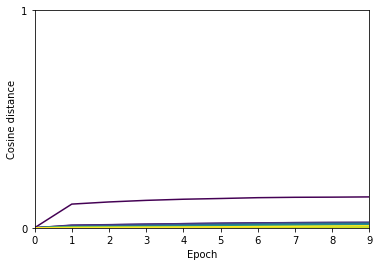

In [29]:
train(model_name='vgg16_wdecay_1', lr=0.00245, epochs=50, batch_size=128, validation_split=0.2, momentum=0.9, layca=False)#, lr_decay=True)

Train on 40000 samples, validate on 10000 samples
Epoch 1/50
40000/40000 [==============================] - 36s 889us/step - loss: 5.9483 - acc: 0.4567 - val_loss: 5.7384 - val_acc: 0.5364
current learning rate: 0.000699999975040555
Epoch 2/50
40000/40000 [==============================] - 20s 510us/step - loss: 5.5679 - acc: 0.6102 - val_loss: 5.6157 - val_acc: 0.5728
current learning rate: 0.000699999975040555
Epoch 3/50
40000/40000 [==============================] - 19s 485us/step - loss: 5.3514 - acc: 0.6966 - val_loss: 5.5147 - val_acc: 0.6271
current learning rate: 0.000699999975040555
Epoch 4/50
40000/40000 [==============================] - 20s 506us/step - loss: 5.1614 - acc: 0.7761 - val_loss: 5.4050 - val_acc: 0.6432
current learning rate: 0.000699999975040555
Epoch 5/50
40000/40000 [==============================] - 21s 532us/step - loss: 4.9826 - acc: 0.8534 - val_loss: 5.4122 - val_acc: 0.6382
current learning rate: 0.000699999975040555
Epoch 6/50
40000/40000 [===========

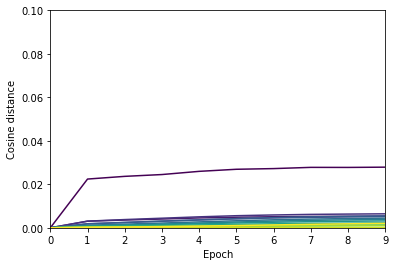

In [168]:
train(model_name='vgg16_wdecay_0', lr=0.0007, epochs=50, batch_size=128, validation_split=0.2, momentum=0.9, layca=False)#, lr_decay=True)

## Layca

Train on 40000 samples, validate on 10000 samples
Epoch 1/50
40000/40000 [==============================] - 34s 842us/step - loss: 1.6134 - acc: 0.4169 - val_loss: 2.0226 - val_acc: 0.3395
current learning rate: 0.029999999329447746
Epoch 2/50
40000/40000 [==============================] - 21s 521us/step - loss: 1.3115 - acc: 0.5642 - val_loss: 2.2508 - val_acc: 0.2541
current learning rate: 0.029999999329447746
Epoch 3/50
40000/40000 [==============================] - 21s 525us/step - loss: 1.1883 - acc: 0.6232 - val_loss: 1.8679 - val_acc: 0.3475
current learning rate: 0.029999999329447746
Epoch 4/50
40000/40000 [==============================] - 21s 528us/step - loss: 1.1349 - acc: 0.6491 - val_loss: 1.5969 - val_acc: 0.4821
current learning rate: 0.029999999329447746
Epoch 5/50
40000/40000 [==============================] - 21s 523us/step - loss: 1.1091 - acc: 0.6612 - val_loss: 1.8490 - val_acc: 0.3978
current learning rate: 0.029999999329447746
Epoch 6/50
40000/40000 [===========

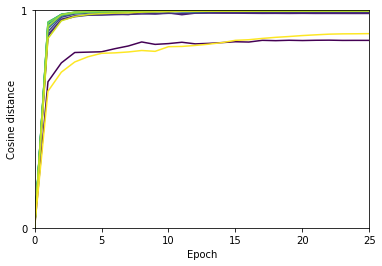

In [162]:
train(model_name='vgg16_layca_2', lr=0.03, epochs=50, batch_size=128, validation_split=0.2, momentum=0.9, layca=True)#, lr_decay=True)

Train on 40000 samples, validate on 10000 samples
Epoch 1/50
40000/40000 [==============================] - 33s 832us/step - loss: 1.4597 - acc: 0.4996 - val_loss: 1.3692 - val_acc: 0.5596
current learning rate: 0.0010000000474974513
Epoch 2/50
40000/40000 [==============================] - 21s 522us/step - loss: 1.0446 - acc: 0.6817 - val_loss: 1.3155 - val_acc: 0.5668
current learning rate: 0.0010000000474974513
Epoch 3/50
40000/40000 [==============================] - 21s 529us/step - loss: 0.8336 - acc: 0.7775 - val_loss: 1.0341 - val_acc: 0.6911
current learning rate: 0.0010000000474974513
Epoch 4/50
40000/40000 [==============================] - 21s 524us/step - loss: 0.6628 - acc: 0.8515 - val_loss: 0.9890 - val_acc: 0.7105
current learning rate: 0.0010000000474974513
Epoch 5/50
40000/40000 [==============================] - 21s 527us/step - loss: 0.5368 - acc: 0.9055 - val_loss: 1.0749 - val_acc: 0.6811
current learning rate: 0.0010000000474974513
Epoch 6/50
40000/40000 [======

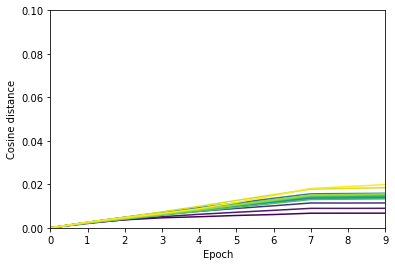

In [160]:
train(model_name='vgg16_layca_1', lr=0.001, epochs=50, batch_size=128, validation_split=0.2, momentum=0.9, layca=True)#, lr_decay=True)

Train on 40000 samples, validate on 10000 samples
Epoch 1/50
40000/40000 [==============================] - 34s 840us/step - loss: 1.6330 - acc: 0.4276 - val_loss: 1.5238 - val_acc: 0.4655
current learning rate: 0.00039999998989515007
Epoch 2/50
40000/40000 [==============================] - 21s 521us/step - loss: 1.2217 - acc: 0.6091 - val_loss: 1.3083 - val_acc: 0.5805
current learning rate: 0.00039999998989515007
Epoch 3/50
40000/40000 [==============================] - 21s 522us/step - loss: 0.9976 - acc: 0.7146 - val_loss: 1.3027 - val_acc: 0.5853
current learning rate: 0.00039999998989515007
Epoch 4/50
40000/40000 [==============================] - 21s 533us/step - loss: 0.7969 - acc: 0.8159 - val_loss: 1.2215 - val_acc: 0.6318
current learning rate: 0.00039999998989515007
Epoch 5/50
40000/40000 [==============================] - 21s 522us/step - loss: 0.6280 - acc: 0.8978 - val_loss: 1.2593 - val_acc: 0.6249
current learning rate: 0.00039999998989515007
Epoch 6/50
40000/40000 [=

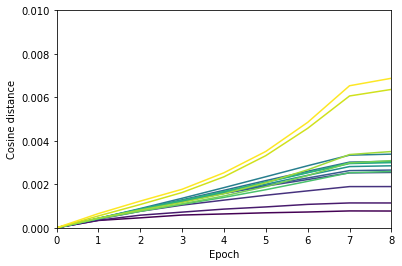

In [161]:
train(model_name='vgg16_layca_0', lr=0.0004, epochs=50, batch_size=128, validation_split=0.2, momentum=0.9, layca=True)#, lr_decay=False)

## Saving models

In [174]:
for name, model in models.items():
    model.save_weights(weights_path(simulation_id, name) + 'final/weights-final.hdf5')

In [ ]:
model.save_weights(weights_path(simulation_id, name) + 'final/weights-final.hdf5')